In [ ]:
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR = "/content/drive/MyDrive/725DATA/"
MNIST_TRAIN = DIR + "mnist_train.csv"
MNIST_TEST = DIR + "mnist_test.csv"
df = pd.read_csv(MNIST_TRAIN)
df.head()
data = df

In [ ]:
import numpy as np
from hashlib import sha256

def sizeOfShard(container, shard):
    '''
    Returns the size (in number of points) of the shard before any unlearning request.
    '''
    shards = np.load(getContainerColabRoot(container) + '/splitfile.npy', allow_pickle=True)
    shard = np.int64(shard)

    return shards[shard].shape[0]

def realSizeOfShard(container, label, shard):
    '''
    Returns the actual size of the shard (including unlearning requests).
    '''
    shards = np.load(getContainerColabRoot(container) + '/splitfile.npy', allow_pickle=True)
    requests = np.load(getContainerColabRoot(container) + '/requestfile:{}.npy'.format(label), allow_pickle=True)

    return shards[shard].shape[0] - requests[shard].shape[0]

def getShardHash(container, label, shard, until=None):
    '''
    Returns a hash of the indices of the points in the shard lower than until
    that are not in the requests (separated by :).
    '''
    shards = np.load(getContainerColabRoot(container) + '/splitfile.npy', allow_pickle=True)
    requests = np.load(getContainerColabRoot(container) + '/requestfile:{}.npy'.format(label), allow_pickle=True)

    if until == None:
        until = shards[shard].shape[0]
    indices = np.setdiff1d(shards[shard][:until], requests[shard])
    string_of_indices = ':'.join(indices.astype(str))
    return sha256(string_of_indices.encode()).hexdigest()

def fetchShardBatch(container, label, shard, batch_size, dataset, offset=0, until=None):
    '''
    Generator returning batches of points in the shard that are not in the requests
    with specified batch_size from the specified dataset
    optionnally located between offset and until (slicing).
    '''
    shards = np.load(getContainerColabRoot(container) + '/splitfile.npy', allow_pickle=True)
    requests = np.load(getContainerColabRoot(container) + '/requestfile:{}.npy'.format(label), allow_pickle=True)

    datasetfile = dataset
    dataloader = datasetfile['dataloader']
    if until == None or until > shards[shard].shape[0]:
        until = shards[shard].shape[0]

    limit = offset
    while limit <= until - batch_size:
        limit += batch_size
        indices = np.setdiff1d(shards[shard][limit-batch_size:limit], requests[shard])
        l = dataloader(indices)
        yield l
    if limit < until:
        indices = np.setdiff1d(shards[shard][limit:until], requests[shard])
        l = dataloader(indices)
        yield l

def fetchTestBatch(dataset, batch_size):
    '''
    Generator returning batches of points from the specified test dataset
    with specified batch_size.
    '''
    datasetfile = dataset
    dataloader = datasetfile['dataloader']
    limit = 0
    while limit <= datasetfile['nb_test'] - batch_size:
        limit += batch_size
        yield dataloader(np.arange(limit - batch_size, limit), category='test')
    if limit < datasetfile['nb_test']:
        yield dataloader(np.arange(limit, datasetfile['nb_test']), category='test')


In [ ]:
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import one_hot
import os
from glob import glob
from time import time


def getCache(container):
    t = "/content/containers/{}/cache".format(container)
    return t
def getTime(container):
    t = "/content/containers/{}/times".format(container)
    return t

def getOutputs(container):
    t = "/content/containers/{}/outputs".format(container)
    return t
def getContainerColabRoot(container):
    t = "/content/containers/{}".format(container)
    return t

class SisaArgs:
    model= None
    train= False
    test= False
    epochs= 20
    batch_size= 16
    dropout_rate= 0.4
    learning_rate= 0.001
    optimizer= "adam"
    output_type= "argmax"
    container= ""
    shard= ""
    slices= 1
    dataset= {}
    chkpt_interval= 1
    label= "latest"

    def __init__(self, model, dataset) -> None:
        self.model = model
        self.dataset = dataset

def sisa(args):
    # Retrive dataset metadata.
    input_shape = tuple(args.dataset["input_shape"])
    nb_classes = args.dataset["nb_classes"]

    # Use GPU if available.
    device = torch.device(
        "cuda:0" if torch.cuda.is_available() else "cpu"
    )  # pylint: disable=no-member

    # Instantiate model and send to selected device.
    # model = model_lib.Model(input_shape, nb_classes, dropout_rate=args.dropout_rate)
    model = args.model(input_shape, nb_classes, dropout_rate=args.dropout_rate)
    model.to(device)

    # Instantiate loss and optimizer.
    loss_fn = CrossEntropyLoss()
    if args.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=args.learning_rate)
    elif args.optimizer == "sgd":
        optimizer = SGD(model.parameters(), lr=args.learning_rate)

    if args.train:
        shard_size = sizeOfShard(args.container, args.shard)
        slice_size = shard_size // args.slices
        avg_epochs_per_slice = (
            2 * args.slices / (args.slices + 1) * args.epochs / args.slices
        )
        loaded = False

        for sl in range(args.slices):
            # Get slice hash using sharded lib.
            slice_hash = getShardHash(
                args.container, args.label, args.shard, until=(sl + 1) * slice_size
            )

            # If checkpoints exists, skip the slice.
            if not os.path.exists(
                getCache(args.container) + "/{}.pt".format(slice_hash)
            ):
                # Initialize state.
                elapsed_time = 0
                start_epoch = 0
                slice_epochs = int((sl + 1) * avg_epochs_per_slice) - int(
                    sl * avg_epochs_per_slice
                )

                # If weights are already in memory (from previous slice), skip loading.
                if not loaded:
                    # Look for a recovery checkpoint for the slice.
                    recovery_list = glob(
                        getCache(args.container) + "/{}_*.pt".format(slice_hash)
                    )
                    if len(recovery_list) > 0:
                        print(
                            "Recovery mode for shard {} on slice {}".format(args.shard, sl)
                        )

                        # Load weights.
                        model.load_state_dict(torch.load(recovery_list[0]))
                        start_epoch = int(
                            recovery_list[0].split("/")[-1].split(".")[0].split("_")[1]
                        )

                        # Load time
                        with open(
                            getTime(args.container) + "/{}_{}.time".format(
                                 slice_hash, start_epoch
                            ),
                            "r",
                        ) as f:
                            elapsed_time = float(f.read())

                    # If there is no recovery checkpoint and this slice is not the first, load previous slice.
                    elif sl > 0:
                        previous_slice_hash = getShardHash(
                            args.container, args.label, args.shard, until=sl * slice_size
                        )

                        # Load weights.
                        model.load_state_dict(
                            torch.load(
                                getCache(args.container) + "/{}.pt".format(
                                    previous_slice_hash
                                )
                            )
                        )

                    # Mark model as loaded for next slices.
                    loaded = True

                # If this is the first slice, no need to load anything.
                elif sl == 0:
                    loaded = True

                # Actual training.
                train_time = 0.0

                for epoch in range(start_epoch, slice_epochs):
                    epoch_start_time = time()

                    for images, labels in fetchShardBatch(
                        args.container,
                        args.label,
                        args.shard,
                        args.batch_size,
                        args.dataset,
                        until=(sl + 1) * slice_size if sl < args.slices - 1 else None,
                    ):

                        # Convert data to torch format and send to selected device.
                        gpu_images = torch.from_numpy(images).to(
                            device
                        )  # pylint: disable=no-member
                        gpu_labels = torch.from_numpy(labels).to(
                            device
                        )  # pylint: disable=no-member

                        forward_start_time = time()

                        # Perform basic training step.
                        logits = model(gpu_images)
                        loss = loss_fn(logits, gpu_labels)

                        optimizer.zero_grad()
                        loss.backward()

                        optimizer.step()

                        train_time += time() - forward_start_time

                    # Create a checkpoint every chkpt_interval.
                    if (
                        args.chkpt_interval != -1
                        and epoch % args.chkpt_interval == args.chkpt_interval - 1
                    ):
                        # Save weights
                        torch.save(
                            model.state_dict(),
                            getCache(args.container) + "/{}_{}.pt".format(
                                slice_hash, epoch
                            ),
                        )

                        # Save time
                        with open(
                            getTime(args.container) + "/{}_{}.time".format(
                                 slice_hash, epoch
                            ),
                            "w",
                        ) as f:
                            f.write("{}\n".format(train_time + elapsed_time))

                        # Remove previous checkpoint.
                        if os.path.exists(
                            getCache(args.container) + "/{}_{}.pt".format(
                                slice_hash, epoch - args.chkpt_interval
                            )
                        ):
                            os.remove(
                                getCache(args.container) + "/{}_{}.pt".format(
                                    slice_hash, epoch - args.chkpt_interval
                                )
                            )
                        if os.path.exists(
                            getTime(args.container) + "/{}_{}.time".format(
                                 slice_hash, epoch - args.chkpt_interval
                            )
                        ):
                            os.remove(
                                getTime(args.container) + "/{}_{}.time".format(
                                     slice_hash, epoch - args.chkpt_interval
                                )
                            )

                # When training is complete, save slice.
                torch.save(
                    model.state_dict(),
                    getCache(args.container) + "/{}.pt".format(slice_hash),
                )
                with open(
                    getTime(args.container) + "/{}.time".format( slice_hash), "w"
                ) as f:
                    f.write("{}\n".format(train_time + elapsed_time))

                # Remove previous checkpoint.
                if os.path.exists(
                    getCache(args.container) + "/{}_{}.pt".format(
                        slice_hash, args.epochs - args.chkpt_interval
                    )
                ):
                    os.remove(
                        getCache(args.container) + "/{}_{}.pt".format(
                            slice_hash, args.epochs - args.chkpt_interval
                        )
                    )
                if os.path.exists(
                    getTime(args.container) + "/{}_{}.time".format(
                         slice_hash, args.epochs - args.chkpt_interval
                    )
                ):
                    os.remove(
                        getTime(args.container) + "/{}_{}.time".format(
                             slice_hash, args.epochs - args.chkpt_interval
                        )
                    )

                # If this is the last slice, create a symlink attached to it.
                if sl == args.slices - 1:
                    os.symlink(
                        "{}.pt".format(slice_hash),
                        getCache(args.container) + "/shard-{}:{}.pt".format(
                            args.shard, args.label
                        ),
                    )
                    os.symlink(
                        "{}.time".format(slice_hash),
                        getTime(args.container) + "/shard-{}:{}.time".format(
                             args.shard, args.label
                        ),
                    )

            elif sl == args.slices - 1:
                os.symlink(
                    "{}.pt".format(slice_hash),
                    getCache(args.container) + "/shard-{}:{}.pt".format(
                        args.shard, args.label
                    ),
                )
                if not os.path.exists(
                    getTime(args.container) + "/shard-{}:{}.time".format(
                         args.shard, args.label
                    )
                ):
                    os.symlink(
                        "null.time",
                        getTime(args.container) + "/shard-{}:{}.time".format(
                             args.shard, args.label
                        ),
                    )


    if args.test:
        # Load model weights from shard checkpoint (last slice).
        model.load_state_dict(
            torch.load(
                getCache(args.container) + "/shard-{}:{}.pt".format(
                    args.shard, args.label
                )
            )
        )

        # Compute predictions batch per batch.
        outputs = np.empty((0, nb_classes))
        for images, _ in fetchTestBatch(args.dataset, args.batch_size):
            # Convert data to torch format and send to selected device.
            gpu_images = torch.from_numpy(images).to(device)  # pylint: disable=no-member

            if args.output_type == "softmax":
                # Actual batch prediction.
                logits = model(gpu_images)
                predictions = softmax(logits, dim=1).to("cpu")  # Send back to cpu.

                # Convert back to numpy and concatenate with previous batches.
                outputs = np.concatenate((outputs, predictions.numpy()))

            else:
                # Actual batch prediction.
                logits = model(gpu_images)
                predictions = torch.argmax(logits, dim=1)  # pylint: disable=no-member

                # Convert to one hot, send back to cpu, convert back to numpy and concatenate with previous batches.
                out = one_hot(predictions, nb_classes).to("cpu")
                outputs = np.concatenate((outputs, out.numpy()))

        # Save outputs in numpy format.
        outputs = np.array(outputs)
        np.save(
            getOutputs(args.container) + "/shard-{}:{}.npy".format(
                args.shard, args.label
            ),
            outputs,
        )


In [ ]:
traindf = pd.read_csv(MNIST_TRAIN)
testdf = pd.read_csv(MNIST_TEST)
# traindf["label"].to_numpy()
xTraindf = traindf.drop("label",  axis=1)
yTraindf = traindf["label"]
xTestdf = testdf.drop("label",  axis=1)
yTestdf = testdf["label"]


In [ ]:
import numpy as np

X_train = xTraindf.to_numpy().astype(np.float32)
X_test = xTestdf.to_numpy().astype(np.float32)
y_train = yTraindf.to_numpy().astype(np.int64)
y_test = yTestdf.to_numpy().astype(np.int64)

def load(indices, category='train'):
  if category == 'train':
      return X_train[indices], y_train[indices]
  elif category == 'test':
      return X_test[indices], y_test[indices]

dataloader = load


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self, input_shape, nb_classes, *args, **kwargs):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_shape[0], 128)
        self.fc2 = nn.Linear(128, nb_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)

        return x

class ModelCNN_MNIST(nn.Module):
    def __init__(self, input_shape, nb_classes, *args, **kwargs):
        super(ModelCNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, nb_classes)

    def forward(self, x):
        x = x.view(-1, 1,28,28).float()
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:

import os.path
from os import path
shards = 10
NUM_REQUESTS = 25
cont = '/content/containers'
sh = cont + "/" + str(shards)
c = sh + "/" + "cache"
o = sh + "/" + "outputs"

def make(dirs):
  for dir in dirs:
    if path.exists(dir) == False:
      os.mkdir(dir)

def makeTimeDir():
  dir = sh + "/" + "times"
  if path.exists(dir) == False:
    !echo 0 > "containers/5/times/null.time"
    os.mkdir(dir)
make([cont, sh, c, o])
makeTimeDir()


In [ ]:
import numpy as np
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.sparse import load_npz
# to_numpy().astype(np.float32)

def KmeansCluster(trainDF, num_class = 10):
    df = trainDF.loc[:, trainDF.columns != 'label']
    data = df.to_numpy().astype(np.float32)
    kmeans = KMeans(n_clusters=num_class, random_state=0).fit(data)
    label = kmeans.labels_
    return label


class DistArgs:
    shards = None
    requests = None
    distribution = "uniform"
    container = "default"
    dataset = {}
    label = "latest"
    data = None
    def __init__(self, dataset, data) -> None:
        self.dataset = dataset
        self.data = data

# Load dataset metadata.
def Distribute(args):
    datasetfile = args.dataset
    data = args.data

    if args.shards != None:
        # If distribution is uniform, split without optimizing.
        if args.distribution == "uniform":
            partition = np.split(
                np.arange(0, datasetfile["nb_train"]),
                [
                    t * (datasetfile["nb_train"] // args.shards)
                    for t in range(1, args.shards)
                ],
            )
            np.save(getContainerColabRoot(args.container) + "/splitfile.npy", partition)
            requests = np.array([[] for _ in range(args.shards)])
            np.save(
                getContainerColabRoot(args.container) + "/requestfile:{}.npy".format(args.label),
                requests,
            )
        elif args.distribution == "kmeans":
            labels = KmeansCluster(data, args.shards)
            partition = [[] for i in range(1, args.shards)]
            for index, row in data.iterrows():
                label = labels.iloc[[index]]
                label = int(label)
                partition[label].append(index)
            np.save(getContainerColabRoot(args.container) + "/splitfile.npy", partition)
            requests = np.array([[] for _ in range(args.shards)])
            np.save(
                getContainerColabRoot(args.container) + "/requestfile:{}.npy".format(args.label),
                requests,
            )

        elif args.distribution == "cluster":
            partition = [[] for i in range(1, args.shards)]
            for index, row in data.iterrows():
                label = row["label"]
                label = int(label)
                partition[label].append(index)
            np.save(getContainerColabRoot(args.container) + "/splitfile.npy", partition)
            requests = np.array([[] for _ in range(args.shards)])
            np.save(
                getContainerColabRoot(args.container) + "/requestfile:{}.npy".format(args.label),
                requests,
            )
    if args.requests != None:
        if args.distribution == "reset":
            requests = np.array([[] for _ in range(partition.shape[0])])
            np.save(
                getContainerColabRoot(args.container) + "/requestfile:{}.npy".format(args.label),
                requests,
            )
        else:
            # Load splitfile.
            partition = np.load(
                getContainerColabRoot(args.container) + "/splitfile.npy", allow_pickle=True
            )

            # Randomly select points to be removed with given distribution at the dataset scale.
            if args.distribution.split(":")[0] == "exponential":
                lbd = (
                    float(args.distribution.split(":")[1])
                    if len(args.distribution.split(":")) > 1
                    else -np.log(0.05) / datasetfile["nb_train"]
                )
                all_requests = np.random.exponential(1 / lbd, (args.requests,))
            if args.distribution.split(":")[0] == "pareto":
                a = (
                    float(args.distribution.split(":")[1])
                    if len(args.distribution.split(":")) > 1
                    else 1.16
                )
                all_requests = np.random.pareto(a, (args.requests,))
            else:
                all_requests = np.random.randint(0, datasetfile["nb_train"], args.requests)

            requests = []
            # Divide up the new requests among the shards.
            for shard in range(partition.shape[0]):
                t = np.intersect1d(partition[shard], all_requests)
                requests.append(t)

            # Update requestfile.
            np.save(
                getContainerColabRoot(args.container) + "/requestfile:{}.npy".format(args.label),
                np.array(requests, dtype=object),
            )


In [ ]:
args = DistArgs({
    "nb_train": 60000,
    "nb_test": 10000,
    "input_shape": [28*28],
    "nb_classes": 10,
    "dataloader": dataloader
}, traindf)
args.shards = shards
args.distribution = "uniform"
args.container = "" + str(shards)
args.label = str(0)
Distribute(args)

for j in range(NUM_REQUESTS):
  args = DistArgs({
    "nb_train": 60000,
    "nb_test": 10000,
    "input_shape": [28*28],
    "nb_classes": 10,
    "dataloader": dataloader
  })
  r=j*shards/5
  args.requests = int(r)
  args.distribution = "kmeans"
  args.container = "" + str(shards)
  args.label = str(int(r))
  Distribute(args)

In [ ]:


args = SisaArgs(None, {
    "nb_train": 60000,
    "nb_test": 10000,
    "input_shape": [28*28],
    "nb_classes": 10,
    "dataloader": dataloader
})



for i in range(shards):
  for j in range(NUM_REQUESTS):
    print("shard: ", i+1, "/", shards, " requests: ", j+1, "/", NUM_REQUESTS)
    r=j*shards/5
    args.train = True
    args.slices = 1
    args.label = str(int(r))
    args.epochs = 20
    args.batch_size = 16
    args.chkpt_interval = 1
    args.container = "" + str(shards)
    args.shard = np.int64(i)
    args.model = Model
    sisa(args)



shard:  1 / 10  requests:  1 / 25
shard:  1 / 10  requests:  2 / 25
shard:  1 / 10  requests:  3 / 25
shard:  1 / 10  requests:  4 / 25
shard:  1 / 10  requests:  5 / 25
shard:  1 / 10  requests:  6 / 25
shard:  1 / 10  requests:  7 / 25
shard:  1 / 10  requests:  8 / 25
shard:  1 / 10  requests:  9 / 25
shard:  1 / 10  requests:  10 / 25
shard:  1 / 10  requests:  11 / 25
shard:  1 / 10  requests:  12 / 25
shard:  1 / 10  requests:  13 / 25
shard:  1 / 10  requests:  14 / 25
shard:  1 / 10  requests:  15 / 25
shard:  1 / 10  requests:  16 / 25
shard:  1 / 10  requests:  17 / 25
shard:  1 / 10  requests:  18 / 25
shard:  1 / 10  requests:  19 / 25
shard:  1 / 10  requests:  20 / 25
shard:  1 / 10  requests:  21 / 25
shard:  1 / 10  requests:  22 / 25
shard:  1 / 10  requests:  23 / 25
shard:  1 / 10  requests:  24 / 25
shard:  1 / 10  requests:  25 / 25
shard:  2 / 10  requests:  1 / 25
shard:  2 / 10  requests:  2 / 25
shard:  2 / 10  requests:  3 / 25
shard:  2 / 10  requests:  4 / 2

In [ ]:
args = SisaArgs(None, {
    "nb_train": 60000,
    "nb_test": 10000,
    "input_shape": [28*28],
    "nb_classes": 10,
    "dataloader": dataloader
})

for i in range(shards):
  for j in range(NUM_REQUESTS):
    print("shard: ", i+1, "/", shards, " requests: ", j+1, "/16")
    r=j*shards/5
    args.test = True
    args.label = str(int(r))
    args.batch_size = 16
    args.container = "" + str(shards)
    args.shard = np.int64(i)
    args.model = Model
    sisa(args)


In [ ]:
import numpy as np
import os

class AggrArgs:
    strategy = "uniform"
    container = ""
    shards = 1
    dataset = {}
    baseline = None
    label = "latest"
    dataset = None

    def __init__(self, dataset) -> None:
        self.dataset = dataset

def Aggregate(args):
    # Load dataset metadata.
    datasetfile = args.dataset
    dataloader = args.dataset["dataloader"]

    # Output files used for the vote.
    if args.baseline != None:
        filenames = ["shard-{}:{}.npy".format(args.baseline, args.label)]
    else:
        filenames = ["shard-{}:{}.npy".format(i, args.label) for i in range(args.shards)]

    # Concatenate output files.
    outputs = []
    for filename in filenames:
        outputs.append(
            np.load(
                getOutputs(args.container) + "/" + filename,
                allow_pickle=True,
            )
        )
    outputs = np.array(outputs)

    # Compute weight vector based on given strategy.
    if args.strategy == "uniform":
        weights = (
            1 / outputs.shape[0] * np.ones((outputs.shape[0],))
        )  # pylint: disable=unsubscriptable-object
    elif args.strategy.startswith("models:"):
        models = np.array(args.strategy.split(":")[1].split(",")).astype(int)
        weights = np.zeros((outputs.shape[0],))  # pylint: disable=unsubscriptable-object
        weights[models] = 1 / models.shape[0]  # pylint: disable=unsubscriptable-object
    elif args.strategy == "proportional":
        split = np.load(
            getContainerColabRoot(args.container) + "/splitfile.npy"
            , allow_pickle=True
        )
        weights = np.array([shard.shape[0] for shard in split])

    # Tensor contraction of outputs and weights (on the shard dimension).
    votes = np.argmax(
        np.tensordot(weights.reshape(1, weights.shape[0]), outputs, axes=1), axis=2
    ).reshape(
        (outputs.shape[1],)
    )  # pylint: disable=unsubscriptable-object

    # Load labels.
    _, labels = dataloader(np.arange(datasetfile["nb_test"]), category="test")

    # Compute and print accuracy.
    accuracy = (
        np.where(votes == labels)[0].shape[0] / outputs.shape[1]
    )  # pylint: disable=unsubscriptable-object
    return accuracy


In [ ]:
args = AggrArgs({
    "nb_train": 60000,
    "nb_test": 10000,
    "input_shape": [28*28],
    "nb_classes": 10,
    "dataloader": dataloader
})

stats = []
for j in range(NUM_REQUESTS):
  r=j*shards/5
  args.strategy = "uniform"
  args.container = "" + str(shards)
  args.shards = shards
  args.label = str(int(r))
  acc = Aggregate(args)
  stats.append(acc)
  print("shards: ", shards, "r:", r, "acc: ", acc)

print(stats)



In [ ]:
# mnist 5 sh ff sgd req 50
# [0.9346, 0.935, 0.9354, 0.9361, 0.9357, 0.9317, 0.9351, 0.9348, 0.935, 0.9345, 0.9343, 0.9347, 0.9356, 0.9347, 0.9362, 0.9335, 0.9327, 0.9349, 0.9349, 0.9366, 0.935, 0.9348, 0.9355, 0.9328, 0.9354, 0.9352, 0.9346, 0.9352, 0.9361, 0.933, 0.9346, 0.934, 0.9335, 0.9366, 0.9346, 0.9345, 0.9347, 0.9347, 0.9344, 0.9353, 0.9342, 0.9353, 0.9349, 0.9333, 0.936, 0.9346, 0.9362, 0.9338, 0.9348, 0.934]

# mnist 5 sh CNN sgd req 50
# [0.9739, 0.9735, 0.9729, 0.9753, 0.9756, 0.9762, 0.9756, 0.9735, 0.9737, 0.9753, 0.9746, 0.9744, 0.9749, 0.9742, 0.9741, 0.9757, 0.9731, 0.9746, 0.9762, 0.9729, 0.9739, 0.9766, 0.9738, 0.9743, 0.9741, 0.9755, 0.9761, 0.9739, 0.9744, 0.9746, 0.9731, 0.9762, 0.9771, 0.9735, 0.9735, 0.9715, 0.9757, 0.9739, 0.9753, 0.9746, 0.9755, 0.9746, 0.9743, 0.9725, 0.9747, 0.9766, 0.9733, 0.9743, 0.9746, 0.9743]

# MNIST 5 sh cnn adam req 50

# MNIST 10 sh cnn adam req 25
# [0.9805, 0.983, 0.9801, 0.9809, 0.9796, 0.9793, 0.98, 0.9801, 0.9815, 0.9802, 0.9816, 0.9802, 0.9813, 0.9798, 0.981, 0.9806, 0.9831, 0.9821, 0.9804, 0.9797, 0.9822, 0.981, 0.9817, 0.9817, 0.9801]

# MNIST 20 sh cnn adam req 25
# [0.9801, 0.9806, 0.9798, 0.98, 0.9805, 0.9794, 0.9794, 0.9781, 0.9798, 0.9794, 0.9802, 0.9814, 0.9789, 0.9796, 0.9791, 0.9793, 0.9807, 0.9785, 0.9798, 0.9799, 0.9809, 0.9802, 0.9802, 0.9806, 0.9809]


# MNIST 50 sh cnn adam req 25



In [ ]:
# !zip -r /content/containers_CNN.zip /content/containers


In [ ]:
a10 = [0.9739, 0.9735, 0.9729, 0.9753, 0.9756, 0.9675]
a20 = [0.9504, 0.9510, 0.9612, 0.945, 0.940, 0.9569]
a50 = [0.9204, 0.9310, 0.9212, 0.945, 0.9256, 0.9154]
a150 = [0.9078, 0.9156, 0.9212, 0.9015, 0.9120, 0.8910]

x = [0,10,20,50,150]

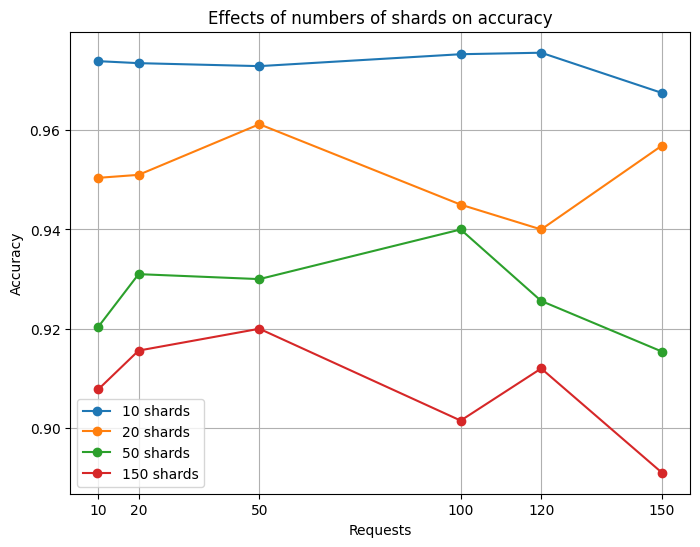

In [38]:
import matplotlib.pyplot as plt

a10 = [0.9739, 0.9735, 0.9729, 0.9753, 0.9756, 0.9675]
a20 = [0.9504, 0.9510, 0.9612, 0.945, 0.940, 0.9569]
a50 = [0.9204, 0.9310, 0.9300, 0.940, 0.9256, 0.9154]
a150 = [0.9078, 0.9156, 0.92, 0.9015, 0.9120, 0.8910]

x = [10, 20, 50, 100, 120, 150]

plt.figure(figsize=(8, 6))

plt.plot(x, a10, marker='o', label='10 shards')
plt.plot(x, a20, marker='o', label='20 shards')
plt.plot(x, a50, marker='o', label='50 shards')
plt.plot(x, a150, marker='o', label='150 shards')

plt.xlabel('Requests')
plt.ylabel('Accuracy')
plt.title('Effects of numbers of shards on accuracy')

plt.xticks(x, x)  # Set X-axis labels to 'X'

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

strong = [0.9812, 0.9835, 0.9854, 0.97145, 0.9878, 0.9875]
weak = [0.9739, 0.9735, 0.9729, 0.9753, 0.9756, 0.9675]

x = [10, 20, 50, 100, 120, 150]

plt.figure(figsize=(8, 6))

plt.plot(x, weak, marker='o', label='Weak Learner (small FF')
plt.plot(x, strong, marker='o', label='Strong Leaner (CNN)')

plt.xlabel('Requests')
plt.ylabel('Accuracy')
plt.title('Effects of model complexity of shard')

plt.xticks(x, x)  # Set X-axis labels to 'X'

plt.legend()
plt.grid(True)
plt.show()
